# Covid 19 Analysis

In [88]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### 3.4) K-Nearest Neighbors
- - -

In [89]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


In [137]:
# define helper functions for the regression tasks
def get_coords_for_country(country, norm=True):
    if norm:
        coords = df.loc[df["Country/Region"] == "US", ["Lat_norm", "Long_norm"]].iloc[0]
    else:
        coords = df.loc[df["Country/Region"] == "US", ["Lat", "Long"]].iloc[0]
    
    return coords[0], coords[1]


def display_graph_country(knn_estimator, country, in_attributes, out_attribute, dataframe):
    country_df = dataframe.loc[df["Country/Region"] == country]
    country_inputs = country_df[in_attributes].values
    country_outputs = country_df[out_attribute].values
    days_list = dataframe["Num_days_from_begin"].unique()
    country_pred_output = knn_estimator.predict(country_inputs)

    first_day = dataframe["Date"].min()
    last_day = dataframe["Date"].max()
    plt.plot(days_list, country_outputs, color='blue', label="Actual " + out_attribute +  " Cases")
    plt.plot(days_list, country_pred_output, color='green', label="Predicted (Nearest Neighbours)")
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(country + " Confirmed Cases vs Prediction from Nearest Neighbours (as of {})".format(last_day))
    plt.legend()
    
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list

def display_graph_country_increment(knn_estimator, country, in_attributes, out_attribute, dataframe):
    country_df = dataframe.loc[df["Country/Region"] == country]
    country_inputs = country_df[in_attributes].values
    country_outputs = country_df[out_attribute + "_inc"].values
    days_list = dataframe["Num_days_from_begin"].unique()
    country_pred_output = knn_estimator.predict(country_inputs)
    
    first_day = dataframe["Date"].min()
    last_day = dataframe["Date"].max()
    
    country_outputs_cumulative = country_df[out_attribute].values
    country_pred_cumulative = calc_cumulative(country_pred_output)

    plt.plot(days_list, country_outputs_cumulative, color='blue', label="Actual Confirmed Cases")
    plt.plot(days_list, country_pred_cumulative, color='green', label="Predicted (Nearest Neighbours)")
    plt.xlabel("Number of days since {}".format(first_day))
    plt.ylabel("# of Cases")
    plt.title(country + " Confirmed Cases vs Prediction from Nearest Neighbours (as of {})".format(last_day))
    plt.legend()


    

## 3.4.1) Regression for Confirmed Cases
- - -

In [91]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

### Normalized inputs, output increment confirmed

In [92]:
# get the inputs of the data for the machine learning algorithm
inputs_non_normalized = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs_non_normalized

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [93]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs_non_normalized, outputs, test_size=0.20, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [94]:
# create K-Nearest Neighbours instance, and check the hyper parameters)
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [95]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

# Training the model with training data
search.fit(in_conf_train, out_conf_train)
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
knn_estimator = search.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min


Best score: -130505.2985546779
Best parameters: {'p': 1, 'n_neighbors': 10, 'leaf_size': 30}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


MAE: 57.55830204081632
MSE: 108143.90960979593
RMSE: 328.85241311231994
R^2: 0.9190541451493467


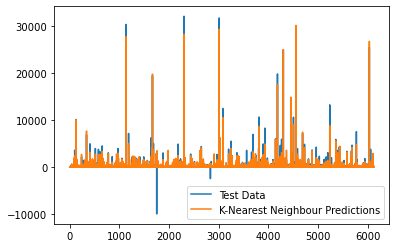

In [96]:
knn_estimator.fit(in_conf_train, out_conf_train) # tirar quando descomentar o que esta em cima
knn_estimator_pred = knn_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(knn_estimator_pred)
plt.legend(['Test Data', 'K-Nearest Neighbour Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, knn_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, knn_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, knn_estimator_pred)))
print('R^2:', r2_score(out_conf_test, knn_estimator_pred))

(array([ 3.,  4.,  9., 12., 16., 27., 30., 36., 42., 21.]),
 array([0.8804406 , 0.88903026, 0.89761992, 0.90620958, 0.91479923,
        0.92338889, 0.93197855, 0.94056821, 0.94915787, 0.95774753,
        0.96633719]),
 <a list of 10 Patch objects>)

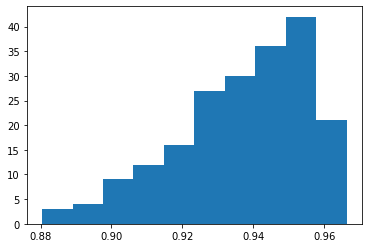

In [97]:
model_accuracies = []

for repetition in range(200):
    (accuracy_in_train,
     accuracy_in_test,
     accuracy_out_train,
     accuracy_out_test) = train_test_split(inputs_non_normalized, outputs, test_size=0.25)
    
    knn_acc = KNeighborsRegressor(p=2, n_neighbors=10, leaf_size=17)
    knn_acc.fit(accuracy_in_train, accuracy_out_train)
    
    classifier_accuracy = knn_estimator.score(accuracy_in_test, accuracy_out_test)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)

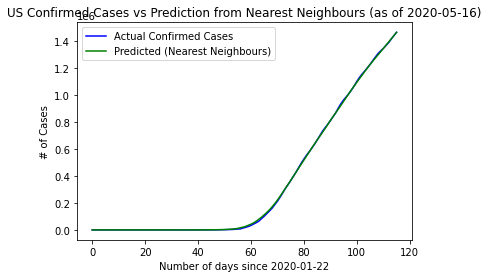

In [98]:
display_graph_country_increment(knn_estimator, "US",["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], "Confirmed", df)

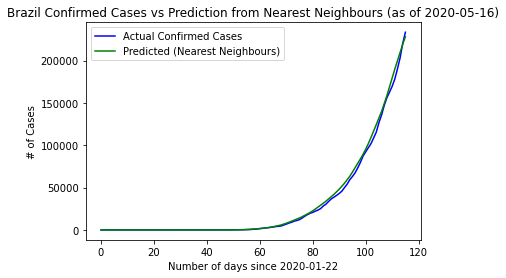

In [99]:
display_graph_country_increment(knn_estimator, "Brazil",["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], "Confirmed", df)

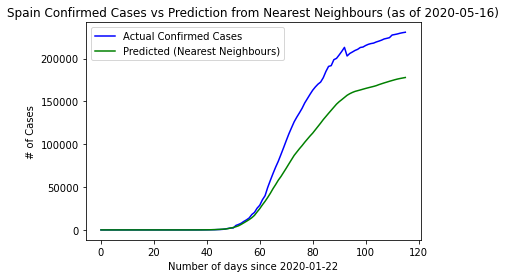

In [100]:
display_graph_country_increment(knn_estimator, "Spain",["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], "Confirmed", df)

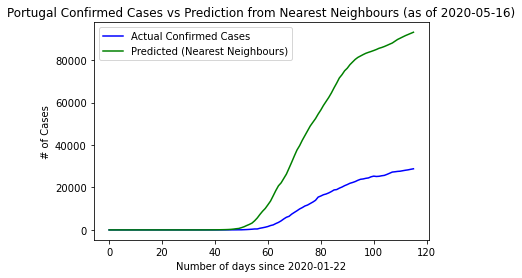

In [101]:
display_graph_country_increment(knn_estimator, "Portugal",["Lat_norm", "Long_norm", "Num_days_from_begin_norm"], "Confirmed", df)

### Non normalized Values, output increment confirmed

In [102]:
# get the inputs of the data for the machine learning algorithm
inputs_normalized = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs_normalized

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [103]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs_normalized, outputs, test_size=0.20, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [104]:
# create K-Nearest Neighbours instance, and check the hyper parameters)
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [105]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

# Training the model with training data
search.fit(in_conf_train, out_conf_train)
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
knn_estimator = search.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min


Best score: -105277.39047858189
Best parameters: {'p': 1, 'n_neighbors': 12, 'leaf_size': 36}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.3min finished


MAE: 65.68149659863946
MSE: 205457.74802947848
RMSE: 453.27447317213716
R^2: 0.9005804169987784


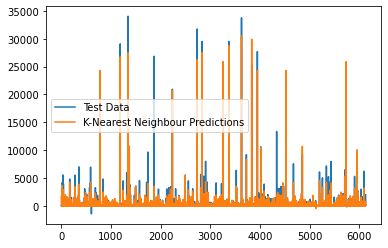

In [106]:
knn_estimator.fit(in_conf_train, out_conf_train) # tirar quando descomentar o que esta em cima
knn_estimator_pred = knn_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(knn_estimator_pred)
plt.legend(['Test Data', 'K-Nearest Neighbour Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, knn_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, knn_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, knn_estimator_pred)))
print('R^2:', r2_score(out_conf_test, knn_estimator_pred))

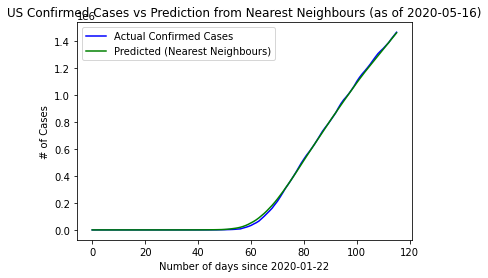

In [107]:
display_graph_country_increment(knn_estimator, "US",["Lat", "Long", "Num_days_from_begin"], "Confirmed", df)

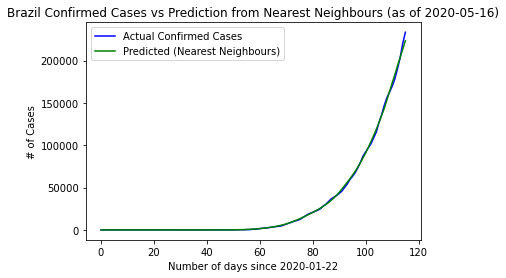

In [108]:
display_graph_country_increment(knn_estimator, "Brazil",["Lat", "Long", "Num_days_from_begin"], "Confirmed", df)

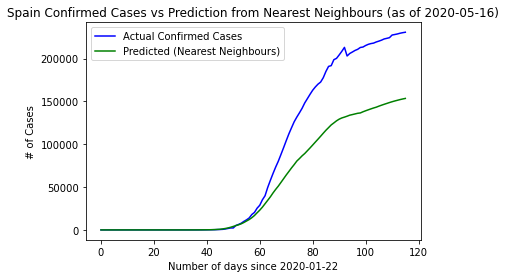

In [109]:
display_graph_country_increment(knn_estimator, "Spain",["Lat", "Long", "Num_days_from_begin"], "Confirmed", df)

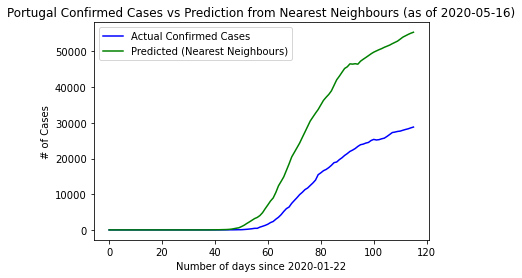

In [110]:
display_graph_country_increment(knn_estimator, "Portugal",["Lat", "Long", "Num_days_from_begin"], "Confirmed", df)

### Normalized values plus the increase in confirmed cases, output confirmed cumulative

In [128]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs_normalized = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs_normalized

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [129]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = new_df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42], dtype=int64)

In [130]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs_normalized, outputs, test_size=0.20, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [131]:
# create K-Nearest Neighbours instance, and check the hyper parameters)
knn = KNeighborsRegressor()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [132]:
# do hyper parameter tuning with the K-Nearest, using cross validation
leaf_size = list(range(10,50))
n_neighbors = list(range(10,30))
p=[1,2]

param_grid = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(knn, param_grid, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)

# Training the model with training data
search.fit(in_conf_train, out_conf_train)
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
knn_estimator = search.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


Best score: -206892932.90610775
Best parameters: {'p': 1, 'n_neighbors': 10, 'leaf_size': 34}


MAE: 1538.3726778656128
MSE: 366896294.1573403
RMSE: 19154.53716896705
R^2: 0.8106858321336728


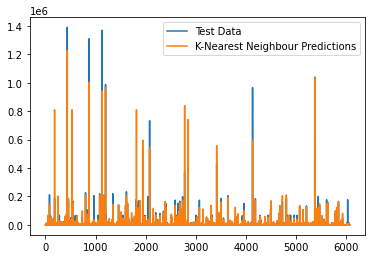

In [133]:
knn_estimator.fit(in_conf_train, out_conf_train) # tirar quando descomentar o que esta em cima
knn_estimator_pred = knn_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(knn_estimator_pred)
plt.legend(['Test Data', 'K-Nearest Neighbour Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, knn_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, knn_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, knn_estimator_pred)))
print('R^2:', r2_score(out_conf_test, knn_estimator_pred))

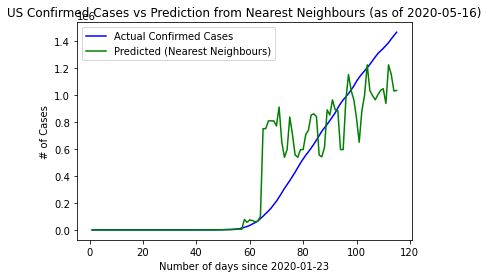

In [138]:
display_graph_country(knn_estimator, "US",["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], "Confirmed", new_df)

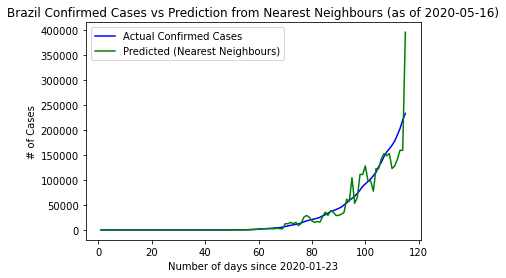

In [139]:
display_graph_country(knn_estimator, "Brazil",["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], "Confirmed", new_df)

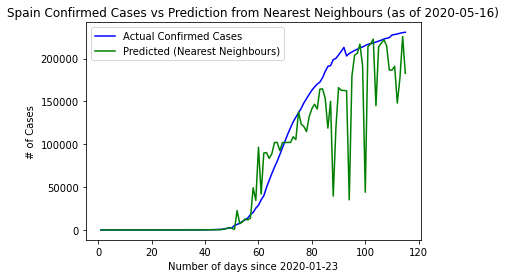

In [140]:
display_graph_country(knn_estimator, "Spain",["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], "Confirmed", new_df)

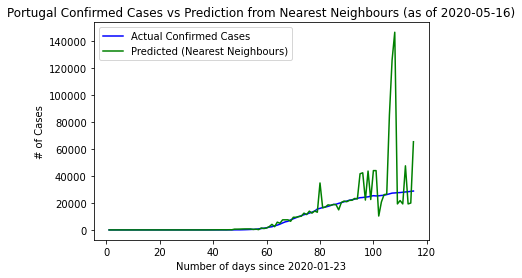

In [141]:
display_graph_country(knn_estimator, "Portugal",["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"], "Confirmed", new_df)

## 3.4.2) Regression for Death Cases

## 3.4.3) Regression for Recovered Cases